In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, recall_score
from imblearn.metrics import specificity_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy import stats as st
from random import randrange

In [2]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200
data = pd.read_csv('clean_pan.csv', index_col='CASEID')


In [3]:
drop = ['PAN_MALIG_HISTOLOGIC','PAN_TSTAGE', 'PAN_NSTAGE', 'PAN_MSTAGE', 'PAN_BENIGN_HISTOLOGIC', 'PAN_BENIGN_TUMORSIZE', 'PAN_NPWT']
data.drop(drop, axis=1, inplace=True)

In [4]:
data.shape

(23233, 73)

In [5]:
data = data.drop(['Unnamed: 0'], axis=1)

In [6]:
y = data['PAN_FISTULA']
X = data.drop(['PAN_FISTULA'], axis=1)

In [7]:
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
fold_no=0
for train_index, test_index in skf.split(data, y):
    train = data.loc[train_index,:]
    test = data.loc[test_index,:]
    train_filename = 'train' + str(fold_no) + '.csv'
    test_filename = 'test' + str(fold_no) + '.csv' 
    train.to_csv('splits/' + train_filename, index=False)
    test.to_csv('splits/' + test_filename, index=False) 
    fold_no += 1

In [8]:
d = {}
for x in range(0,5):
    d['train{}'.format(x)] = pd.read_csv('splits/train{}.csv'.format(x), low_memory=False)
    d['test{}'.format(x)] = pd.read_csv('splits/test{}.csv'.format(x), low_memory=False)

In [9]:
dX_train = []
dy_train = []
for x in d:
    if 'train' in x:
        dX_train.append(d[x].drop(columns=['PAN_FISTULA'], axis=1))
        dy_train.append(d[x]['PAN_FISTULA'])

In [10]:
dX_test = []
dy_test = []
for x in d:
    if 'test' in x:
        dX_test.append(d[x].drop(columns=['PAN_FISTULA'], axis=1))
        dy_test.append(d[x]['PAN_FISTULA'])

rfpreds = []
xgbpreds = []
model = RandomForestClassifier(n_estimators=1250, min_samples_split=2, min_samples_leaf=8, max_features='auto', max_depth=20, bootstrap=True)
model2 = XGBClassifier(n_estimators=50, subsample=0.6, min_child_weight=10, max_depth=6, learning_rate=0.1, colsample_bytree=0.8)
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    model.fit(X, y)
    model2.fit(X, y)
    rfpreds.append(model.predict_proba(X_test))
    xgbpreds.append(model2.predict_proba(X_test))

%store rfpreds
%store xgbpreds

for x in range(0,5):
    print(roc_auc_score(dy_test[x], rfpreds[x][:,1]))
    

for x in range(0,5):
    print(roc_auc_score(dy_test[x], xgbpreds[x][:,1]))

In [11]:
from tensorflow import keras
input_shape = [X.shape[1]]
model4 = keras.models.Sequential()
model4.add(keras.layers.Flatten(input_shape=input_shape))
model4.add(keras.layers.BatchNormalization())
for _ in range(2):
    model4.add(keras.layers.Dense(1000))
    model4.add(keras.layers.BatchNormalization())
    model4.add(keras.layers.Dropout(0.8))
    model4.add(keras.layers.Activation("relu"))
model4.add(keras.layers.Dense(1, activation="sigmoid"))

opt = keras.optimizers.Adam(learning_rate=3e-4)

metrics = [keras.metrics.Recall(name='Sensitivity'), keras.metrics.TrueNegatives(name='tn'), keras.metrics.AUC(name='auc'), keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.00001,
    restore_best_weights=True,)


In [12]:
annpreds = []
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
    model4.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping])
    annpreds.append(model4.predict(X_test))

Epoch 1/200
28/28 [==============================] - 3s 40ms/step - loss: 0.7175 - Sensitivity: 0.2215 - tn: 9427.0000 - auc: 0.5277 - prc: 0.1768 - val_loss: 0.5348 - val_Sensitivity: 0.0577 - val_tn: 3796.0000 - val_auc: 0.6689 - val_prc: 0.2939
Epoch 2/200
28/28 [==============================] - 0s 11ms/step - loss: 0.6174 - Sensitivity: 0.1403 - tn: 10692.0000 - auc: 0.5770 - prc: 0.2104 - val_loss: 0.5292 - val_Sensitivity: 0.1568 - val_tn: 3657.0000 - val_auc: 0.6818 - val_prc: 0.3022
Epoch 3/200
28/28 [==============================] - 0s 11ms/step - loss: 0.5952 - Sensitivity: 0.1606 - tn: 10635.0000 - auc: 0.6002 - prc: 0.2263 - val_loss: 0.5156 - val_Sensitivity: 0.1468 - val_tn: 3664.0000 - val_auc: 0.6919 - val_prc: 0.3095
Epoch 4/200
28/28 [==============================] - 0s 12ms/step - loss: 0.5896 - Sensitivity: 0.1734 - tn: 10698.0000 - auc: 0.5963 - prc: 0.2328 - val_loss: 0.4976 - val_Sensitivity: 0.1267 - val_tn: 3697.0000 - val_auc: 0.6906 - val_prc: 0.3062
Epoch

In [13]:
ann_score = []
for x in range(0,5):
    ann_score.append(roc_auc_score(dy_test[x], annpreds[x]))
ann_score

[0.7180616650896982,
 0.7274891749965453,
 0.727476481035362,
 0.7350018288848013,
 0.7383036475485197]

model.fit(dX_train[0], dy_train[0])
def rf_feat_importance(model, X):
    return pd.DataFrame({'cols':X.columns, 'imp':model.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(model, X)
fi[:10]
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:20]);

model2.fit(dX_train[0], dy_train[0])
fi = rf_feat_importance(model2, X)
plot_fi(fi[:20]);

In [14]:
lrpreds = []
model3 = LogisticRegression()
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    model3.fit(X, y)
    lrpreds.append(model3.predict_proba(X_test))
lr_score = []
for x in range(0,5):
    lr_score.append(roc_auc_score(dy_test[x], lrpreds[x][:,1]))
lr_score

/home/kchen/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kchen/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

[0.6970648140774465,
 0.7007366376464447,
 0.6894455678840845,
 0.6942496046187894,
 0.7001425781358832]

lr_ci = stats.norm.interval(0.95, loc=np.mean(lr_score), scale=np.std(lr_score))
print(lr_ci)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)

def evaluate(model1, X, y):
    ppreds = model1.predict_proba(X)
    ppreds = ppreds[:,1]
    pscore = roc_auc_score(y, ppreds)
    print('AUC', pscore)
model = RandomForestClassifier()
model.fit(X_train, y_train)
evaluate(model, X_valid, y_valid)



def rf_feat_importance(model, X):
    return pd.DataFrame({'cols':X.columns, 'imp':model.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(model, X)
fi[:10]
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(8,4), legend=False)

plot_fi(fi[:10]);

In [15]:
ann_mean = np.mean(ann_score)
ann_confidence = st.t.interval(0.95, len(ann_score)-1, loc=ann_mean, scale=st.sem(ann_score))

print('Neural Network:', round(ann_mean,3), '('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')')


Neural Network: 0.729 (0.72-0.739)


In [16]:
lr_mean = np.mean(lr_score)
lr_confidence = st.t.interval(0.95, len(lr_score)-1, loc=lr_mean, scale=st.sem(lr_score))

print('Logistic Regression:', round(lr_mean,3), '('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')')


Logistic Regression: 0.696 (0.691-0.702)


In [17]:
ann_prc = []
for x in range(0,5):
    ann_prc.append(average_precision_score(dy_test[x], annpreds[x]))

ann_prc_mean = np.mean(ann_prc)
ann_prc_confidence = st.t.interval(0.95, len(ann_prc)-1, loc=ann_prc_mean, scale=st.sem(ann_prc))

print('Neural Network:', round(ann_prc_mean,3), '('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')
lr_prc = []
for x in range(0,5):
    lr_prc.append(average_precision_score(dy_test[x], lrpreds[x][:,1]))

lr_prc_mean = np.mean(lr_prc)
lr_prc_confidence = st.t.interval(0.95, len(lr_prc)-1, loc=lr_prc_mean, scale=st.sem(lr_prc))

print('Logistic Regression:', round(lr_prc_mean,3), '('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')')
with open('pan_results.txt', 'w') as f:
    f.write('Logistic Regression: '+str(round(lr_mean,3))+' ('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_mean,3))+' ('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')\n')
    f.write('AUPRC\n')
    f.write('Logistic Regression: '+str(round(lr_prc_mean,3))+' ('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_prc_mean,3))+' ('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')

Neural Network: 0.358 (0.34-0.375)
Logistic Regression: 0.312 (0.289-0.334)


In [18]:
for x in range(0,5):
    print(len(annpreds[x]))

4647
4647
4647
4646
4646


pan_ann_tpr = []
pan_ann_fpr = []
for x in range(0,5):
    fpr, tpr, thresholds = roc_curve(dy_test[x], annpreds[x])
    pan_ann_tpr.append(tpr)
    pan_ann_fpr.append(fpr)
pan_ann_tpr_array = [np.array(x) for x in pan_ann_tpr]
mean_pan_ann_tpr = [np.mean(k) for k in zip(*pan_ann_tpr_array)]
pan_ann_fpr_array = [np.array(x) for x in pan_ann_fpr]
mean_pan_ann_fpr = [np.mean(k) for k in zip(*pan_ann_fpr_array)]
%store mean_pan_ann_tpr
%store mean_pan_ann_fpr


for x in range(0,5):
    pan_ann_tpr[x] = np.random.permutation(pan_ann_tpr[x])
pan_ann_tpr = [x[:1000] for x in pan_ann_tpr]
for x in range(0,5):
    pan_ann_tpr[x] = sorted(pan_ann_tpr[x])
for x in range(0,5):
    pan_ann_fpr[x] = np.random.permutation(pan_ann_fpr[x])
pan_ann_fpr = [x[:1000] for x in pan_ann_fpr]
for x in range(0,5):
    pan_ann_fpr[x] = sorted(pan_ann_fpr[x])

pan_ann_tpr_array = [np.array(x) for x in pan_ann_tpr]
mean_pan_ann_tpr = [np.mean(k) for k in zip(*pan_ann_tpr_array)]
pan_ann_fpr_array = [np.array(x) for x in pan_ann_fpr]
mean_pan_ann_fpr = [np.mean(k) for k in zip(*pan_ann_fpr_array)]
%store mean_pan_ann_tpr
%store mean_pan_ann_fpr

In [19]:
pan_ann_tpr = []
pan_ann_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], annpreds[x])
    pan_ann_tpr.append(tpr)
    pan_ann_fpr.append(fpr)


In [20]:
for x in range(0,5):
    print(len(pan_ann_fpr[x]))
    

1149
1222
1122
1177
1133


In [21]:
for x in range(0,5):
    diff = len(pan_ann_tpr[x]) - 1100
    for _ in range(diff):
        ind = randrange(len(pan_ann_tpr[x]))
        pan_ann_tpr[x] = np.delete(pan_ann_tpr[x],ind)
for x in range(0,5):
    diff = len(pan_ann_fpr[x]) - 1100
    for _ in range(diff):
        ind = randrange(len(pan_ann_fpr[x]))
        pan_ann_fpr[x] = np.delete(pan_ann_fpr[x],ind)


mean_pan_ann_tpr = [np.mean(k) for k in zip(*pan_ann_tpr)]

mean_pan_ann_fpr = [np.mean(k) for k in zip(*pan_ann_fpr)]
%store mean_pan_ann_tpr
%store mean_pan_ann_fpr

Stored 'mean_pan_ann_tpr' (list)
Stored 'mean_pan_ann_fpr' (list)


In [22]:
pan_lr_tpr = []
pan_lr_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], lrpreds[x][:,1])
    pan_lr_tpr.append(tpr)
    pan_lr_fpr.append(fpr)


In [23]:
for x in range(0,5):
    print(len(pan_lr_fpr[x]))

1178
1248
1144
1220
1152


In [24]:
for x in range(0,5):
    diff = len(pan_lr_tpr[x]) - 1100
    for _ in range(diff):
        ind = randrange(len(pan_lr_tpr[x]))
        pan_lr_tpr[x] = np.delete(pan_lr_tpr[x],ind)

for x in range(0,5):
    diff = len(pan_lr_fpr[x]) - 1100
    for _ in range(diff):
        ind = randrange(len(pan_lr_fpr[x]))
        pan_lr_fpr[x] = np.delete(pan_lr_fpr[x],ind)


mean_pan_lr_tpr = [np.mean(k) for k in zip(*pan_lr_tpr)]

mean_pan_lr_fpr = [np.mean(k) for k in zip(*pan_lr_fpr)]
%store mean_pan_lr_tpr
%store mean_pan_lr_fpr

Stored 'mean_pan_lr_tpr' (list)
Stored 'mean_pan_lr_fpr' (list)


In [25]:
pan_lr_rec = []
pan_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    pan_lr_rec.append(rec)
    pan_lr_prec.append(prec)


In [26]:
for x in range(0,5):
    print(len(pan_lr_rec[x]))

4615
4619
4633
4564
4617


In [27]:

for x in range(0,5):
    diff = len(pan_lr_rec[x]) - 4564
    for _ in range(diff):
        ind = randrange(len(pan_lr_rec[x]))
        pan_lr_rec[x] = np.delete(pan_lr_rec[x],ind)

for x in range(0,5):
    diff = len(pan_lr_prec[x]) - 4564
    for _ in range(diff):
        ind = randrange(len(pan_lr_prec[x]))
        pan_lr_prec[x] = np.delete(pan_lr_prec[x],ind)

mean_pan_lr_rec = [np.mean(k) for k in zip(*pan_lr_rec)]

mean_pan_lr_prec = [np.mean(k) for k in zip(*pan_lr_prec)]
%store mean_pan_lr_rec
%store mean_pan_lr_prec

Stored 'mean_pan_lr_rec' (list)
Stored 'mean_pan_lr_prec' (list)


In [28]:
pan_ann_rec = []
pan_ann_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], annpreds[x])
    pan_ann_rec.append(rec)
    pan_ann_prec.append(prec)


In [29]:
for x in range(0,5):
    print(len(pan_ann_rec[x]))

4614
4640
4641
4528
4594


In [30]:

for x in range(0,5):
    diff = len(pan_ann_rec[x]) - 4482
    for _ in range(diff):
        ind = randrange(len(pan_ann_rec[x]))
        pan_ann_rec[x] = np.delete(pan_ann_rec[x],ind)

for x in range(0,5):
    diff = len(pan_ann_prec[x]) - 4482
    for _ in range(diff):
        ind = randrange(len(pan_ann_prec[x]))
        pan_ann_prec[x] = np.delete(pan_ann_prec[x],ind)

mean_pan_ann_rec = [np.mean(k) for k in zip(*pan_ann_rec)]

mean_pan_ann_prec = [np.mean(k) for k in zip(*pan_ann_prec)]
%store mean_pan_ann_rec
%store mean_pan_ann_prec

Stored 'mean_pan_ann_rec' (list)
Stored 'mean_pan_ann_prec' (list)


pan_lr_rec = []
pan_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    pan_lr_rec.append(rec)
    pan_lr_prec.append(prec)

for x in range(0,5):
    pan_lr_rec[x] = np.random.permutation(pan_lr_rec[x])
pan_lr_rec = [x[:1000] for x in pan_lr_rec]
for x in range(0,5):
    pan_lr_rec[x] = sorted(pan_lr_rec[x])
for x in range(0,5):
    pan_lr_prec[x] = np.random.permutation(pan_lr_prec[x])
pan_lr_prec = [x[:1000] for x in pan_lr_prec]
for x in range(0,5):
    pan_lr_prec[x] = sorted(pan_lr_prec[x])
pan_lr_rec_array = [np.array(x) for x in pan_lr_rec]
mean_pan_lr_rec = [np.mean(k) for k in zip(*pan_lr_rec_array)]
pan_lr_prec_array = [np.array(x) for x in pan_lr_prec]
mean_pan_lr_prec = [np.mean(k) for k in zip(*pan_lr_prec_array)]
%store mean_pan_lr_rec
%store mean_pan_lr_prec

from matplotlib import pyplot as plt

plt.plot(mean_pan_ann_rec, mean_pan_ann_prec)

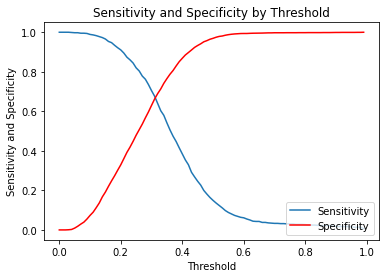

In [31]:
thresh = np.arange(0, 1, 0.01)
#calculate recall at 10 thresholds
annrecall_list = []
for i in thresh:
    annrecall_list.append(recall_score(dy_test[1], annpreds[1] > i))
#calculate spec at 10 thresholds
annspec_list = []
for i in thresh:
    annspec_list.append(specificity_score(dy_test[1], annpreds[1] > i))
from matplotlib import pyplot as plt
#plot recall vs threshold
plt.plot(thresh, annrecall_list, label = 'Sensitivity')
plt.plot(thresh, annspec_list, color = 'red', label = 'Specificity')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity by Threshold')
plt.legend(loc="lower right")
plt.show()

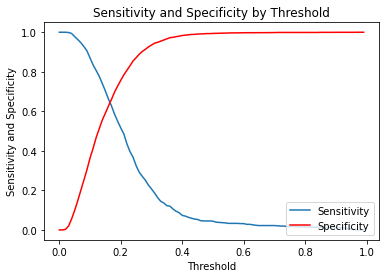

In [32]:
thresh = np.arange(0, 1, 0.01)
#calculate recall at 10 thresholds
lrrecall_list = []
for i in thresh:
    lrrecall_list.append(recall_score(dy_test[1], lrpreds[1][:,1] > i))
#calculate spec at 10 thresholds
lrspec_list = []
for i in thresh:
    lrspec_list.append(specificity_score(dy_test[1], lrpreds[1][:,1] > i))
from matplotlib import pyplot as plt
#plot recall vs threshold
plt.plot(thresh, lrrecall_list, label = 'Sensitivity')
plt.plot(thresh, lrspec_list, color = 'red', label = 'Specificity')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity by Threshold')
plt.legend(loc="lower right")
plt.show()

In [33]:
print(recall_score(dy_test[1], lrpreds[1][:,1] > 0.15))
print(specificity_score(dy_test[1], lrpreds[1][:,1] > 0.15))

0.7022058823529411
0.591229444009397


In [34]:
print(recall_score(dy_test[1], annpreds[1] > 0.3))
print(specificity_score(dy_test[1], annpreds[1] > 0.3))

0.6764705882352942
0.6622291829809449


In [35]:
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics

def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])
def kernel(X, Y):
    return .5 if Y==X else int(Y < X)
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    

def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))


p = []
z = []
# Model A (random) vs. "good" model B
for x in range(0,5):
    preds_A = annpreds[x]
    preds_B = lrpreds[x][:,1]
    actual = dy_test[x]

    actual = actual.array

    def group_preds_by_label(preds, actual):
        X = [p for (p, a) in zip(preds, actual) if a]
        Y = [p for (p, a) in zip(preds, actual) if not a]
        return X, Y


    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)
    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)
    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)


    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

    # Two tailed test
    z.append(z_score(var_A, var_B, covar_AB, auc_A, auc_B))
    p.append(st.norm.sf(abs(z[x-1]))*2)


for x in range(0,5):
    print(p[x])

2.7897590379779105e-05
2.7897590379779105e-05
1.117043731858687e-09
4.4069142168588157e-13
1.458630300534831e-16
